In [69]:
import pandas as pd
import numpy as np
import tensorflow as tf
import itertools
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [70]:
train = pd.read_csv('data/ner_dataset.csv')
train['Word'] = train['Word'].map(str.lower)
train.head(8)

,Sentence #,Word,POS,Tag
0,Sentence: 1,thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,london,NNP,B-geo
7,NaN,to,TO,O


In [71]:
with open('data/penn_trebank.txt', 'tr') as f:
    content = f.readlines()

tidy = {}
for i in range(0, len(content)-1, 2):
    tidy[content[i].strip()] = content[i+1].strip()

In [72]:
tags_for_removal = set(train['POS'].values)- set(tidy.keys())
print(f'tags in training, but not in the original treebank set: {tags_for_removal}')

tags in training, but not in the original treebank set: {'LRB', ':', '.', ';', '$', '``', ',', 'RRB'}


In [73]:
train = train[train['POS'].map(lambda x: x not in tags_for_removal)]

In [74]:
UNK = '<UNK>'
POS_UNK = '<POS_UNK>'

In [75]:
# Decide on the features to determine the window size for training
input_data = []
for tup in train[['Word', 'POS', 'Tag']].itertuples(index = False, name=None):
    input_data.append(tup)
input_data[:20]

[('thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('london', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('british', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O')]

In [104]:
sequence_length = 3

def create_windowed_dataset(input_dat, sequence_length=3, mode='train'):
    matrix = []
    for index in range(len(input_dat)):
        if index+sequence_length>len(input_dat):
            break
        if mode=='train':
            matrix.append(input_dat[index:index+sequence_length])
        else:
            matrix.append([(a, None) for a in input_dat[index:index+sequence_length]])
        index+=sequence_length
    return matrix

matrix = create_windowed_dataset(input_data)


In [105]:
matrix[:5]

[[('thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O')],
 [('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O')],
 [('demonstrators', 'NNS', 'O'),
  ('have', 'VBP', 'O'),
  ('marched', 'VBN', 'O')],
 [('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O')],
 [('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('london', 'NNP', 'B-geo')]]

In [106]:
from collections import defaultdict

In [107]:
suffixes = []
for item in set(train['Word']):
    suffixes.append(item[-3:])
        
pos_vocab = set([POS_UNK]) 
pos_vocab.update(train['POS'])

index_to_pos = {k:v for k, v in enumerate(pos_vocab)}
pos_to_index = defaultdict(None, {v:k for k, v in index_to_pos.items()})

tag_vocab = set(train['Tag'])
index_to_tag = {k:v for k, v in enumerate(tag_vocab)}
tag_to_index = {v:k for k, v in index_to_tag.items()}

word_vocab = set([UNK])
word_vocab.update(train['Word'])
print(len(word_vocab))

word_vocab.update(suffixes)
print(len(word_vocab))

index_to_word = {k+len(pos_vocab): v for k, v in enumerate(word_vocab)}
word_to_index = defaultdict(None, {v:k for k, v in index_to_word.items()})

print(len(word_vocab), len(pos_vocab), len(tag_vocab))

31798
34751
34751 35 17


In [108]:
pos_to_index

defaultdict(None,
            {'PRP$': 0,
             'WRB': 1,
             'VBG': 2,
             'EX': 3,
             'NNPS': 4,
             'UH': 5,
             'PDT': 6,
             'WP$': 7,
             'VBP': 8,
             'RBR': 9,
             'NNP': 10,
             'NN': 11,
             'VB': 12,
             'JJ': 13,
             'CD': 14,
             'JJR': 15,
             'MD': 16,
             'RP': 17,
             'VBD': 18,
             'CC': 19,
             'PRP': 20,
             'VBZ': 21,
             'IN': 22,
             'NNS': 23,
             'POS': 24,
             'FW': 25,
             '<POS_UNK>': 26,
             'WP': 27,
             'JJS': 28,
             'TO': 29,
             'DT': 30,
             'WDT': 31,
             'VBN': 32,
             'RBS': 33,
             'RB': 34})

In [109]:
len(sorted(list(pos_vocab)))

35

In [110]:
def build_features(row, mode='train'):
    features = []
    
    features.append(word_to_index.get(row[1][0].lower(), word_to_index[UNK]))
    features.append(word_to_index.get(row[1][0][-3:], word_to_index[UNK]))
#    features.append(row[1][0][-2:])
    features.append(int(row[1][0].istitle()))
    features.append(int(row[1][0].isupper()))    
    features.append(int(row[1][0].isdigit()))    
    features.append(pos_to_index.get(row[1][1], pos_to_index[POS_UNK]))
#    features.append(row[1][1][:2])    
    
    
    features.append(word_to_index.get(row[0][0].lower(), word_to_index[UNK]))
    features.append(int(row[0][0].istitle()))
    features.append(int(row[0][0].isupper()))   
    features.append(pos_to_index.get(row[0][1], pos_to_index[POS_UNK]))
#    features.append(row[0][1][:2])    

    features.append(word_to_index.get(row[2][0].lower(), word_to_index[UNK]))
    features.append(int(row[2][0].istitle()))
    features.append(int(row[2][0].isupper()))
    features.append(pos_to_index.get(row[2][1], pos_to_index[POS_UNK]))
#    features.append(row[2][1][:2])    

    if mode=='train':
        features.append(tag_to_index[row[1][2]])
        
    return features
    
build_features(matrix[0])

[19159, 19159, 0, 0, 0, 22, 11787, 0, 0, 23, 30841, 0, 0, 23, 5]

In [111]:
transformed_matrix = []

for row in matrix:
    features = build_features(row)    
    transformed_matrix.append(features)  

In [112]:
len(transformed_matrix[0])

15

In [113]:
def get_model(vocab_size, d_model):

    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=d_model, input_length=14))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(.1))
    model.add(layers.Dense(len(tag_vocab), activation='sigmoid'))

    return model

In [114]:
model = get_model(len(word_vocab)+len(pos_vocab)+len(tag_vocab), 100)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 14, 100)           3480300   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1400)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               140100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 17)                1717      
Total params: 3,622,117
Trainable params: 3,622,117
Non-trainable params: 0
_________________________________________________________________


In [115]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy()
              , metrics=[keras.metrics.CategoricalAccuracy()])

In [116]:
X, y = np.array(transformed_matrix)[:, :-1], keras.utils.to_categorical(np.array(transformed_matrix)[:, -1], num_classes=len(tag_vocab))
X.shape, y.shape

((960742, 14), (960742, 17))

In [117]:
max_train_size = 10000
X_train = X[:max_train_size]
X_test = X[max_train_size:max_train_size+int(.1*max_train_size)]

y_train = y[:max_train_size]
y_test = y[max_train_size:max_train_size+int(.1*max_train_size)]

In [118]:
CHECKPOINT_DIR = 'data/model/ner_checkpoint'

Epoch 1/10
313/313 [==============================] - 9s 28ms/step - loss: 0.8153 - categorical_accuracy: 0.8467 - val_loss: 0.1822 - val_categorical_accuracy: 0.9430
INFO:tensorflow:Assets written to: data/model/ner_checkpoint/assets
Epoch 2/10
313/313 [==============================] - 9s 27ms/step - loss: 0.1851 - categorical_accuracy: 0.9556 - val_loss: 0.1219 - val_categorical_accuracy: 0.9630
INFO:tensorflow:Assets written to: data/model/ner_checkpoint/assets
Epoch 3/10
313/313 [==============================] - 9s 28ms/step - loss: 0.0822 - categorical_accuracy: 0.9784 - val_loss: 0.1193 - val_categorical_accuracy: 0.9690
INFO:tensorflow:Assets written to: data/model/ner_checkpoint/assets
Epoch 4/10
313/313 [==============================] - 9s 28ms/step - loss: 0.0409 - categorical_accuracy: 0.9884 - val_loss: 0.1371 - val_categorical_accuracy: 0.9650
Epoch 5/10
313/313 [==============================] - 9s 27ms/step - loss: 0.0214 - categorical_accuracy: 0.9943 - val_loss: 0.1

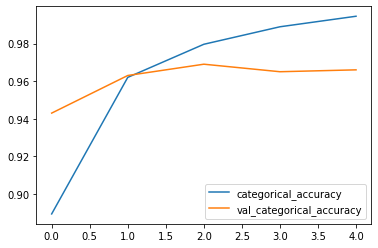

In [119]:
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_test, y_test), 
                    batch_size=32, 
                    epochs=10, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=2), 
                               tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_DIR, monitor='val_categorical_accuracy',
                                                                save_best_only=True)])

for key in ['categorical_accuracy', 'val_categorical_accuracy']:
    plt.plot(history.history[key], label=key)
plt.legend()
plt.show()

In [16]:
#model.save('data/ner_model/')
#model = keras.models.load_model('data/model/ner_checkpoint')

In [120]:
results = []
for a in range(1000):
    results.append(np.argmax(model.predict(X_test[a].reshape(1,-1)))==np.argmax(y_test[a]))
    if not a%100:
        print(np.mean(results))

1.0
0.9702970297029703
0.9701492537313433
0.973421926910299
0.9750623441396509
0.9660678642714571
0.9650582362728786
0.9671897289586305
0.968789013732834
0.9644839067702553


In [121]:
it = train[['Word', 'POS', 'Tag']].itertuples(index=False, name=None)
row = []
for a in range (5):
    row.append(next(it))

In [122]:
row

[('thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O')]

In [123]:
features = build_features(row, mode='predict')
features

[19159, 19159, 0, 0, 0, 22, 11787, 0, 0, 23, 30841, 0, 0, 23]

In [124]:
prediction = model.predict(np.array(features).reshape(1,-1))
np.argmax(prediction)

5

In [125]:
index_to_tag[10]

'I-gpe'

In [2]:
#model = keras.models.load_model('data/ner_model/')

In [126]:
bleak_pos = pd.read_csv('data/pos_tagged_bleak_house_FULL.csv')

In [127]:
bleak_pos = bleak_pos.drop(bleak_pos.columns[0], axis='columns')

In [128]:
matrix = create_windowed_dataset(list(bleak_pos.itertuples(index=False, name=None)))

In [129]:
matrix[:5]

[[('In', 'IN'), ('Chancery', 'NNP'), ('London', 'NNP')],
 [('Chancery', 'NNP'), ('London', 'NNP'), ('Michaelmas', 'NNP')],
 [('London', 'NNP'), ('Michaelmas', 'NNP'), ('term', 'NN')],
 [('Michaelmas', 'NNP'), ('term', 'NN'), ('lately', 'RB')],
 [('term', 'NN'), ('lately', 'RB'), ('over', 'IN')]]

In [130]:
feature_matrix = [build_features(row, mode='predict') for row in matrix]
# for row in matrix:
# #     print(row)
#     features = build_features(row, mode='predict')
#     print(index_to_tag[np.argmax(model.predict(np.array(features).reshape(1,-1)))])

In [131]:
arr = np.array(feature_matrix)
arr

array([[18916, 30837,     1, ...,     1,     0,    10],
       [15765, 23632,     1, ...,     1,     0,    10],
       [18916,  7163,     1, ...,     0,     0,    11],
       ...,
       [20600,   378,     0, ...,     0,     0,    11],
       [20031,  9714,     0, ...,     0,     0,    22],
       [18514, 18514,     0, ...,     0,     0,    20]])

In [132]:
pred_numbers = model.predict(arr)

In [133]:
predictions = np.argmax(pred_numbers, axis=1)

In [189]:
ner_tagged_book = [(index_to_tag[a], b[1]) for a, b in zip(predictions, matrix)]

In [190]:
len(predictions)

358606

In [191]:
len(matrix)

358606

In [192]:
ner_tagged_book[0]

('B-geo', ('Chancery', 'NNP'))

In [193]:
named_entities = []
current_chain = None

for i in range(len(ner_tagged_book)):
    current_line = ner_tagged_book[i]
    if re.match('O', current_line[0]):
        continue
        
    if re.match('B-', current_line[0]):
        if current_chain:
            named_entities.append((i, current_chain, len(current_chain)))
        current_chain = [current_line]
    else:
        current_chain.append(current_line)

In [215]:
named_entities[:10]

[(1, [('B-geo', ('Chancery', 'NNP'))], 1),
 (8, [('B-geo', ('London', 'NNP')), ('I-geo', ('Michaelmas', 'NNP'))], 2),
 (12, [('B-org', ('Lord', 'NNP')), ('I-org', ('Chancellor', 'NNP'))], 2),
 (14, [('B-geo', ('Lincoln', 'NNP'))], 1),
 (17,
  [('B-geo', ('Inn', 'NNP')),
   ('I-per', ('Hall', 'NNP')),
   ('I-per', ('Implacable', 'NNP'))],
  3),
 (48, [('B-tim', ('November', 'NNP'))], 1),
 (60, [('B-art', ('Megalosaurus', 'NNP'))], 1),
 (212,
  [('B-geo', ('Holborn', 'NNP')),
   ('I-per', ('Hill', 'NNP')),
   ('I-per', ('Smoke', 'NNP'))],
  3),
 (217, [('B-org', ('Essex', 'NNP'))], 1),
 (219, [('B-gpe', ('Kentish', 'JJ'))], 1)]

In [214]:
Counter([' '.join([word[1][0] for word in named_entity[1]]) for named_entity in named_entities]).most_common(10)

[('Richard', 387),
 ('Mr. Bucket', 340),
 ('Mr. Guppy', 302),
 ('Sir Leicester', 285),
 ('Mr. Tulkinghorn', 263),
 ('Mr. George', 224),
 ('Mr. Jarndyce', 219),
 ('Ada', 208),
 ('Mr. Snagsby', 201),
 ('Charley', 196)]